# Data Augmentation

In [24]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# 데이터셋 디렉터리 경로
dataset_dir = '/content/drive/MyDrive/dataset_real'
# train_dir = os.path.join(dataset_dir, 'train')
# val_dir = os.path.join(dataset_dir, 'val')

# 사진 크기
image_height = 224
image_width = 224
batch_size = 32



train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



# 훈련셋에서 배치를 생성
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1006 files belonging to 4 classes.
Using 805 files for training.
Found 1006 files belonging to 4 classes.
Using 201 files for validation.
(32, 224, 224, 3)
(32,)


# Model 1 (Original)

In [27]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [29]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [31]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 9s 316ms/step - loss: 24.6813 - mae: 4.3564 - val_loss: 16.3691 - val_mae: 3.5230
Epoch 2/10
26/26 [==============================] - 8s 304ms/step - loss: 14.9922 - mae: 3.2783 - val_loss: 10.6886 - val_mae: 2.6779
Epoch 3/10
26/26 [==============================] - 8s 305ms/step - loss: 10.1516 - mae: 2.5896 - val_loss: 7.8979 - val_mae: 2.2101
Epoch 4/10
26/26 [==============================] - 8s 306ms/step - loss: 8.0257 - mae: 2.2162 - val_loss: 6.9014 - val_mae: 2.0201
Epoch 5/10
26/26 [==============================] - 8s 307ms/step - loss: 7.1812 - mae: 2.0508 - val_loss: 6.3862 - val_mae: 1.9333
Epoch 6/10
26/26 [==============================] - 8s 307ms/step - loss: 6.6121 - mae: 1.9627 - val_loss: 5.9541 - val_mae: 1.8501
Epoch 7/10
26/26 [==============================] - 8s 305ms/step - loss: 6.1425 - mae: 1.8828 - val_loss: 5.5645 - val_mae: 1.7997
Epoch 8/10
26/26 [==============================] - 8s 306ms/step - los

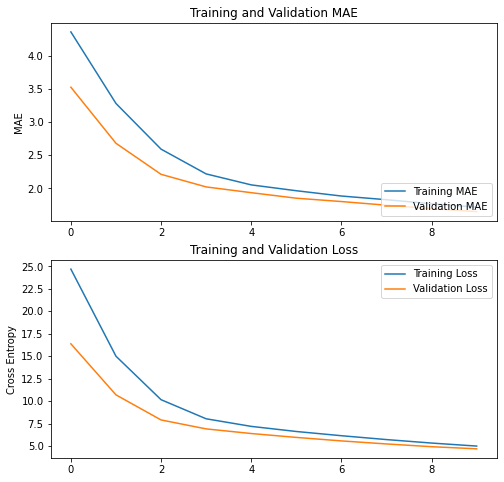

In [32]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 2 (Only Horizontal)

In [33]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal')
])

In [34]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [36]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [37]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [38]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 10s 319ms/step - loss: 9.8802 - mae: 2.4220 - val_loss: 7.7580 - val_mae: 2.2231
Epoch 2/10
26/26 [==============================] - 8s 311ms/step - loss: 8.6846 - mae: 2.2588 - val_loss: 6.9171 - val_mae: 2.0957
Epoch 3/10
26/26 [==============================] - 8s 308ms/step - loss: 8.0703 - mae: 2.1524 - val_loss: 6.5117 - val_mae: 2.0327
Epoch 4/10
26/26 [==============================] - 8s 308ms/step - loss: 7.5453 - mae: 2.0953 - val_loss: 6.0542 - val_mae: 1.9606
Epoch 5/10
26/26 [==============================] - 8s 308ms/step - loss: 6.9919 - mae: 2.0018 - val_loss: 5.7374 - val_mae: 1.9051
Epoch 6/10
26/26 [==============================] - 8s 307ms/step - loss: 6.3849 - mae: 1.9308 - val_loss: 5.4273 - val_mae: 1.8495
Epoch 7/10
26/26 [==============================] - 8s 310ms/step - loss: 5.8588 - mae: 1.8548 - val_loss: 5.2106 - val_mae: 1.8075
Epoch 8/10
26/26 [==============================] - 8s 308ms/step - loss: 5

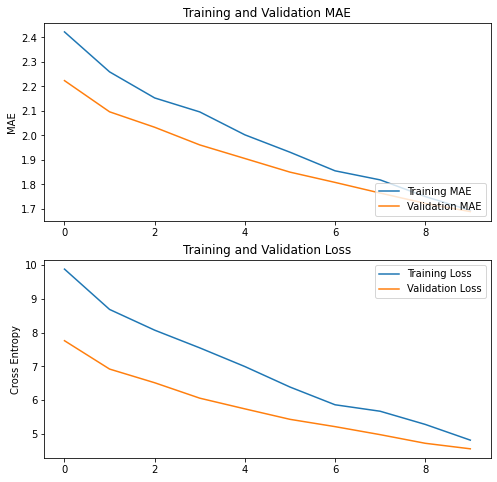

In [39]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 3 (Random Rotation 0.2)

In [40]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [41]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [43]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [44]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [45]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 10s 323ms/step - loss: 7.6840 - mae: 2.2100 - val_loss: 7.3385 - val_mae: 2.1737
Epoch 2/10
26/26 [==============================] - 9s 313ms/step - loss: 6.0820 - mae: 1.9387 - val_loss: 6.1938 - val_mae: 1.9955
Epoch 3/10
26/26 [==============================] - 9s 315ms/step - loss: 5.5114 - mae: 1.8623 - val_loss: 5.7905 - val_mae: 1.9302
Epoch 4/10
26/26 [==============================] - 9s 312ms/step - loss: 5.9413 - mae: 1.8967 - val_loss: 5.2201 - val_mae: 1.8248
Epoch 5/10
26/26 [==============================] - 9s 315ms/step - loss: 4.6769 - mae: 1.6463 - val_loss: 4.9392 - val_mae: 1.7715
Epoch 6/10
26/26 [==============================] - 9s 311ms/step - loss: 4.8603 - mae: 1.7112 - val_loss: 4.7813 - val_mae: 1.7422
Epoch 7/10
26/26 [==============================] - 9s 314ms/step - loss: 4.7128 - mae: 1.6804 - val_loss: 4.5145 - val_mae: 1.6826
Epoch 8/10
26/26 [==============================] - 9s 314ms/step - loss: 4

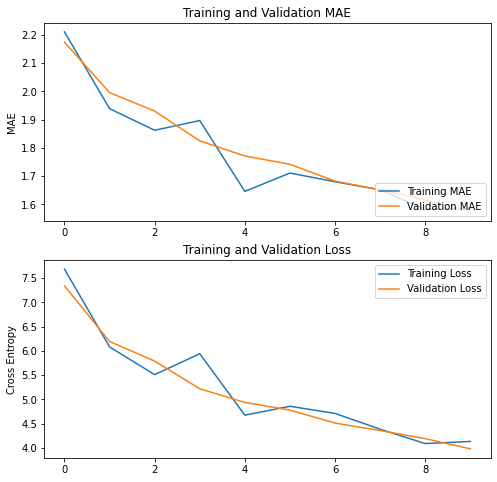

In [46]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 4 (Random Rotation 0.5)

In [47]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.5),
])

In [48]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [50]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [51]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_6   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [52]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 10s 321ms/step - loss: 34.3474 - mae: 5.1664 - val_loss: 31.5747 - val_mae: 4.9437
Epoch 2/10
26/26 [==============================] - 8s 311ms/step - loss: 19.1390 - mae: 3.6882 - val_loss: 20.9566 - val_mae: 3.8676
Epoch 3/10
26/26 [==============================] - 9s 312ms/step - loss: 12.2994 - mae: 2.8259 - val_loss: 13.7733 - val_mae: 3.0189
Epoch 4/10
26/26 [==============================] - 8s 311ms/step - loss: 8.5665 - mae: 2.3284 - val_loss: 10.1008 - val_mae: 2.5428
Epoch 5/10
26/26 [==============================] - 8s 310ms/step - loss: 7.2618 - mae: 2.1191 - val_loss: 8.6132 - val_mae: 2.3240
Epoch 6/10
26/26 [==============================] - 8s 311ms/step - loss: 6.6984 - mae: 2.0052 - val_loss: 7.8139 - val_mae: 2.1954
Epoch 7/10
26/26 [==============================] - 9s 312ms/step - loss: 6.6810 - mae: 2.0308 - val_loss: 6.8419 - val_mae: 2.0420
Epoch 8/10
26/26 [==============================] - 8s 310ms/step - 

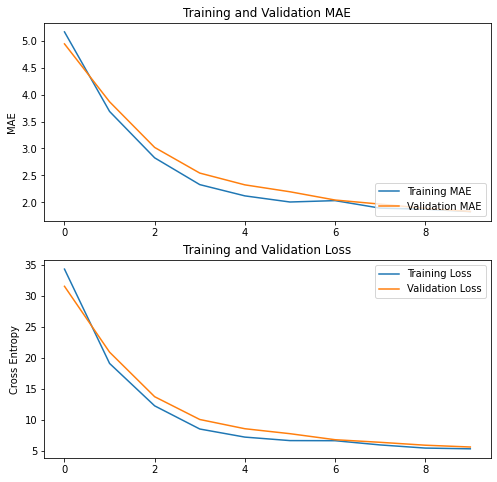

In [53]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()